In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sqlite3
from sqlite3 import Error
from sklearn.linear_model import LinearRegression
from tsmoothie.smoother import *
import gensim
import json
import ast

In [3]:
def connect_to_database(db_file):
    """ create a database connection to the SQLite database
        specified by the db_file
    :param db_file: database file
    :return: Connection object or None
    """
    conn = None
    try:
        conn = sqlite3.connect(db_file)
    except Error as e:
        print(e)

    return conn

In [4]:
DB_FILE = 'data/reddit_50_both_inferred.db'

# get connection with database
conn = connect_to_database(DB_FILE)
cur = conn.cursor()
conn.text_factory = lambda b: b.decode(errors = 'ignore')

In [14]:
import pickle
# wta_df = pickle.load(infile)
wta_df = pd.read_pickle('data/word_topic_assignments.pkl')

In [ ]:
gensim_dictionary = gensim.corpora.dictionary.Dictionary.load("LDA/RC_LDA_Dict_True.dict")

In [ ]:
def convert_to_list(entry):
    if isinstance(entry, str):
        return ast.literal_eval(entry)

for index, row in wta_df.iterrows():
    if index % 1000 == 0:
        print(index)
    
    if isinstance(row[1], str):
        row[1] = ast.literal_eval(row[1])

# wta_df.to_pickle('wta_df_new.pkl')

In [8]:
# GENERICITY NEW

TOPIC = 0

generic_phis = {}
total_phis = {}
unclear_phis = {}
specific_phis = {}

generic_temporal_phis = {}
total_temporal_phis = {}
unclear_temporal_phis = {}
specific_temporal_phis = {}

for index, row in wta_df.iterrows():

    # get clauses and date from database for the doc_id
    doc_id = row[0]
    cur.execute("SELECT * FROM classified_clauses where doc_id = ?", (int(doc_id),))
    classificiation = cur.fetchall()
    cur.execute("SELECT * FROM comments where rowid = ?", (int(doc_id),))
    comment = cur.fetchall()
    month = comment[0][3]
    year = comment[0][4]
    date = str(month) + '-' + str(year)

    if int(doc_id) % 1000 == 0:
        print(doc_id)

    if classificiation:
        clauses = classificiation[0][1]
        genericity_preds = classificiation[0][2].split(',')

        for word_assignment in row[1]:

            word = gensim_dictionary[word_assignment[0]]

            assignment = ()
            for index, clause in enumerate(clauses.split('\n')):
                if word in clause:
                    # check if it is generic or specific
                    prediction = int(genericity_preds[index])
                    if prediction == 0: # generic
                        for assignment in word_assignment[1]:
                            topic = assignment[0]
                            phi = assignment[1]

                            # temporal dictionary
                            if date in generic_temporal_phis:
                                temp = generic_temporal_phis[date]
                                if topic in temp:
                                    temp_phi = temp[topic][1]
                                    temp_count = temp[topic][0]
                                    generic_temporal_phis[date][topic] = (temp_count + 1, (phi + temp_phi))          
                                    total_temporal_phis[date][topic] = (temp_count + 1, (phi + temp_phi))          
                                else:
                                    generic_temporal_phis[date][topic] = (1, phi)
                                    total_temporal_phis[date][topic] = (1, phi)
                            else:
                                print('adding to dict', date)
                                generic_temporal_phis[date] = {topic:(1, phi)}
                                total_temporal_phis[date] = {topic:(1, phi)}

                            # total generic_phis
                            if topic in generic_phis:
                                generic_phis[topic] += phi
                            else:
                                generic_phis[topic] = phi

                            # total 
                            if topic in total_phis:
                                total_phis[topic] += phi
                            else:
                                total_phis[topic] = phi

                    elif prediction == 1: #specific
                        for assignment in word_assignment[1]:
                            topic = assignment[0]
                            phi = assignment[1]

                            # temporal dictionary
                            if date in specific_temporal_phis:
                                temp = specific_temporal_phis[date]
                                if topic in temp:
                                    temp_phi = temp[topic][1]
                                    temp_count = temp[topic][0]
                                    specific_temporal_phis[date][topic] = (temp_count + 1, (phi + temp_phi))          
                                    total_temporal_phis[date][topic] = (temp_count + 1, (phi + temp_phi))          
                                else:
                                    specific_temporal_phis[date][topic] = (1, phi)
                                    total_temporal_phis[date][topic] = (1, phi)
                            else:
                                specific_temporal_phis[date] = {topic:(1, phi)}
                                total_temporal_phis[date] = {topic:(1, phi)}

                            if topic in specific_phis:
                                specific_phis[topic] += phi
                            else:
                                specific_phis[topic] = phi

                            if topic in total_phis:
                                total_phis[topic] += phi
                            else:
                                total_phis[topic] = phi
                    else:
                        for assignment in word_assignment[1]:
                            topic = assignment[0]
                            phi = assignment[1]

                            # temporal dictionary
                            if date in unclear_temporal_phis:
                                temp = unclear_temporal_phis[date]
                                if topic in temp:
                                    temp_phi = temp[topic][1]
                                    temp_count = temp[topic][0]
                                    unclear_temporal_phis[date][topic] = (temp_count + 1, (phi + temp_phi))          
                                    total_temporal_phis[date][topic] = (temp_count + 1, (phi + temp_phi))          
                                else:
                                    unclear_temporal_phis[date][topic] = (1, phi)
                                    total_temporal_phis[date][topic] = (1, phi)
                            else:
                                unclear_temporal_phis[date] = {topic:(1, phi)}
                                total_temporal_phis[date] = {topic:(1, phi)}

                            if topic in unclear_phis:
                                unclear_phis[topic] += phi
                            else:
                                unclear_phis[topic] = phi

                            if topic in total_phis:
                                total_phis[topic] += phi
                            else:
                                total_phis[topic] = phi



00
720000
adding to dict 5-2014
721000
722000
723000
724000
725000
726000
727000
728000
729000
730000
731000
732000
733000
734000
735000
736000
737000
738000
739000
740000
adding to dict 6-2014
741000
742000
743000
744000
745000
746000
747000
748000
749000
750000
751000
752000
753000
754000
755000
756000
757000
adding to dict 7-2014
758000
759000
760000
761000
762000
763000
764000
765000
766000
767000
768000
769000
770000
771000
772000
773000
774000
775000
776000
777000
778000
779000
adding to dict 8-2014
780000
781000
782000
783000
784000
785000
786000
787000
788000
789000
790000
791000
792000
793000
794000
795000
796000
797000
798000
799000
800000
adding to dict 9-2014
801000
802000
803000
804000
805000
806000
807000
808000
809000
810000
811000
812000
813000
814000
815000
816000
817000
818000
adding to dict 10-2014
819000
820000
821000
822000
823000
824000
825000
826000
827000
828000
829000
830000
831000
832000
833000
834000
835000
836000
837000
838000
adding to dict 11-2014
839000
8

In [23]:
# BOUNDEDNESS NEW

TOPIC = 0

bounded_phis = {}
total_phis = {}
unclear_phis = {}
specific_phis = {}

bounded_temporal_phis = {}
total_temporal_phis = {}
unbounded_temporal_phis = {}

for index, row in wta_df.iterrows():

    # get clauses and date from database for the doc_id
    doc_id = row[0]
    cur.execute("SELECT * FROM classified_clauses where doc_id = ?", (int(doc_id),))
    classificiation = cur.fetchall()
    cur.execute("SELECT * FROM comments where rowid = ?", (int(doc_id),))
    comment = cur.fetchall()
    month = comment[0][3]
    year = comment[0][4]
    date = str(month) + '-' + str(year)

    if int(doc_id) % 1000 == 0:
        print(doc_id)

    if classificiation:
        clauses = classificiation[0][1]
        boundedness_preds = classificiation[0][6].split(',')

        for word_assignment in row[1]:

            word = gensim_dictionary[word_assignment[0]]

            assignment = ()
            for index, clause in enumerate(clauses.split('\n')):
                if word in clause:
                    # check if it is generic or specific
                    prediction = int(boundedness_preds[index])
                    if prediction == 0: # bounded
                        for assignment in word_assignment[1]:
                            topic = assignment[0]
                            phi = assignment[1]

                            # temporal dictionary
                            if date in bounded_temporal_phis:
                                temp = bounded_temporal_phis[date]
                                if topic in temp:
                                    temp_phi = temp[topic][1]
                                    temp_count = temp[topic][0]
                                    bounded_temporal_phis[date][topic] = (temp_count + 1, (phi + temp_phi))          
                                    total_temporal_phis[date][topic] = (temp_count + 1, (phi + temp_phi))          
                                else:
                                    bounded_temporal_phis[date][topic] = (1, phi)
                                    total_temporal_phis[date][topic] = (1, phi)
                            else:
                                print('adding to dict', date)
                                bounded_temporal_phis[date] = {topic:(1, phi)}
                                total_temporal_phis[date] = {topic:(1, phi)}

                            # total bounded_phis
                            if topic in bounded_phis:
                                bounded_phis[topic] += phi
                            else:
                                bounded_phis[topic] = phi

                            # total 
                            if topic in total_phis:
                                total_phis[topic] += phi
                            else:
                                total_phis[topic] = phi

                    elif prediction == 1: #unbounded
                        for assignment in word_assignment[1]:
                            topic = assignment[0]
                            phi = assignment[1]

                            # temporal dictionary
                            if date in unbounded_temporal_phis:
                                temp = unbounded_temporal_phis[date]
                                if topic in temp:
                                    temp_phi = temp[topic][1]
                                    temp_count = temp[topic][0]
                                    unbounded_temporal_phis[date][topic] = (temp_count + 1, (phi + temp_phi))          
                                    total_temporal_phis[date][topic] = (temp_count + 1, (phi + temp_phi))          
                                else:
                                    unbounded_temporal_phis[date][topic] = (1, phi)
                                    total_temporal_phis[date][topic] = (1, phi)
                            else:
                                unbounded_temporal_phis[date] = {topic:(1, phi)}
                                total_temporal_phis[date] = {topic:(1, phi)}

                            if topic in unbounded_phis:
                                unbounded_phis[topic] += phi
                            else:
                                unbounded_phis[topic] = phi

                            if topic in total_phis:
                                total_phis[topic] += phi
                            else:
                                total_phis[topic] = phi
                    else:
                        for assignment in word_assignment[1]:
                            topic = assignment[0]
                            phi = assignment[1]

                            # temporal dictionary
                            if date in unclear_temporal_phis:
                                temp = unclear_temporal_phis[date]
                                if topic in temp:
                                    temp_phi = temp[topic][1]
                                    temp_count = temp[topic][0]
                                    unclear_temporal_phis[date][topic] = (temp_count + 1, (phi + temp_phi))          
                                    total_temporal_phis[date][topic] = (temp_count + 1, (phi + temp_phi))          
                                else:
                                    unclear_temporal_phis[date][topic] = (1, phi)
                                    total_temporal_phis[date][topic] = (1, phi)
                            else:
                                unclear_temporal_phis[date] = {topic:(1, phi)}
                                total_temporal_phis[date] = {topic:(1, phi)}

                            if topic in unclear_phis:
                                unclear_phis[topic] += phi
                            else:
                                unclear_phis[topic] = phi

                            if topic in total_phis:
                                total_phis[topic] += phi
                            else:
                                total_phis[topic] = phi



00
720000
adding to dict 5-2014
721000
722000
723000
724000
725000
726000
727000
728000
729000
730000
731000
732000
733000
734000
735000
736000
737000
738000
739000
740000
adding to dict 6-2014
741000
742000
743000
744000
745000
746000
747000
748000
749000
750000
751000
752000
753000
754000
755000
756000
757000
adding to dict 7-2014
758000
759000
760000
761000
762000
763000
764000
765000
766000
767000
768000
769000
770000
771000
772000
773000
774000
775000
776000
777000
778000
779000
adding to dict 8-2014
780000
781000
782000
783000
784000
785000
786000
787000
788000
789000
790000
791000
792000
793000
794000
795000
796000
797000
798000
799000
800000
adding to dict 9-2014
801000
802000
803000
804000
805000
806000
807000
808000
809000
810000
811000
812000
813000
814000
815000
816000
817000
818000
adding to dict 10-2014
819000
820000
821000
822000
823000
824000
825000
826000
827000
828000
829000
830000
831000
832000
833000
834000
835000
836000
837000
838000
adding to dict 11-2014
839000
8

In [26]:
# ASPECT NEW

TOPIC = 0

dynamic_phis = {}
total_phis = {}
unclear_phis = {}
stative_phis = {}

dynamic_temporal_phis = {}
total_temporal_phis = {}
unclear_temporal_phis = {}
stative_temporal_phis = {}

for index, row in wta_df.iterrows():

    # get clauses and date from database for the doc_id
    doc_id = row[0]
    cur.execute("SELECT * FROM classified_clauses where doc_id = ?", (int(doc_id),))
    classificiation = cur.fetchall()
    cur.execute("SELECT * FROM comments where rowid = ?", (int(doc_id),))
    comment = cur.fetchall()
    month = comment[0][3]
    year = comment[0][4]
    date = str(month) + '-' + str(year)

    if int(doc_id) % 1000 == 0:
        print(doc_id)

    if classificiation:
        clauses = classificiation[0][1]
        aspect_preds = classificiation[0][4].split(',')

        for word_assignment in row[1]:

            word = gensim_dictionary[word_assignment[0]]

            assignment = ()
            for index, clause in enumerate(clauses.split('\n')):
                if word in clause:
                    # check if it is generic or specific
                    prediction = int(aspect_preds[index])
                    if prediction == 0: # dynamic
                        for assignment in word_assignment[1]:
                            topic = assignment[0]
                            phi = assignment[1]

                            # temporal dictionary
                            if date in dynamic_temporal_phis:
                                temp = dynamic_temporal_phis[date]
                                if topic in temp:
                                    temp_phi = temp[topic][1]
                                    temp_count = temp[topic][0]
                                    dynamic_temporal_phis[date][topic] = (temp_count + 1, (phi + temp_phi))          
                                    total_temporal_phis[date][topic] = (temp_count + 1, (phi + temp_phi))          
                                else:
                                    dynamic_temporal_phis[date][topic] = (1, phi)
                                    total_temporal_phis[date][topic] = (1, phi)
                            else:
                                print('adding to dict', date)
                                dynamic_temporal_phis[date] = {topic:(1, phi)}
                                total_temporal_phis[date] = {topic:(1, phi)}

                            # total dynamic_phis
                            if topic in dynamic_phis:
                                dynamic_phis[topic] += phi
                            else:
                                dynamic_phis[topic] = phi

                            # total 
                            if topic in total_phis:
                                total_phis[topic] += phi
                            else:
                                total_phis[topic] = phi

                    elif prediction == 1: #stative
                        for assignment in word_assignment[1]:
                            topic = assignment[0]
                            phi = assignment[1]

                            # temporal dictionary
                            if date in stative_temporal_phis:
                                temp = stative_temporal_phis[date]
                                if topic in temp:
                                    temp_phi = temp[topic][1]
                                    temp_count = temp[topic][0]
                                    stative_temporal_phis[date][topic] = (temp_count + 1, (phi + temp_phi))          
                                    total_temporal_phis[date][topic] = (temp_count + 1, (phi + temp_phi))          
                                else:
                                    stative_temporal_phis[date][topic] = (1, phi)
                                    total_temporal_phis[date][topic] = (1, phi)
                            else:
                                stative_temporal_phis[date] = {topic:(1, phi)}
                                total_temporal_phis[date] = {topic:(1, phi)}

                            if topic in stative_phis:
                                stative_phis[topic] += phi
                            else:
                                stative_phis[topic] = phi

                            if topic in total_phis:
                                total_phis[topic] += phi
                            else:
                                total_phis[topic] = phi
                    else: # unclear
                        for assignment in word_assignment[1]:
                            topic = assignment[0]
                            phi = assignment[1]

                            # temporal dictionary
                            if date in unclear_temporal_phis:
                                temp = unclear_temporal_phis[date]
                                if topic in temp:
                                    temp_phi = temp[topic][1]
                                    temp_count = temp[topic][0]
                                    unclear_temporal_phis[date][topic] = (temp_count + 1, (phi + temp_phi))          
                                    total_temporal_phis[date][topic] = (temp_count + 1, (phi + temp_phi))          
                                else:
                                    unclear_temporal_phis[date][topic] = (1, phi)
                                    total_temporal_phis[date][topic] = (1, phi)
                            else:
                                unclear_temporal_phis[date] = {topic:(1, phi)}
                                total_temporal_phis[date] = {topic:(1, phi)}

                            if topic in unclear_phis:
                                unclear_phis[topic] += phi
                            else:
                                unclear_phis[topic] = phi

                            if topic in total_phis:
                                total_phis[topic] += phi
                            else:
                                total_phis[topic] = phi



00
720000
adding to dict 5-2014
721000
722000
723000
724000
725000
726000
727000
728000
729000
730000
731000
732000
733000
734000
735000
736000
737000
738000
739000
740000
adding to dict 6-2014
741000
742000
743000
744000
745000
746000
747000
748000
749000
750000
751000
752000
753000
754000
755000
756000
757000
adding to dict 7-2014
758000
759000
760000
761000
762000
763000
764000
765000
766000
767000
768000
769000
770000
771000
772000
773000
774000
775000
776000
777000
778000
779000
adding to dict 8-2014
780000
781000
782000
783000
784000
785000
786000
787000
788000
789000
790000
791000
792000
793000
794000
795000
796000
797000
798000
799000
800000
adding to dict 9-2014
801000
802000
803000
804000
805000
806000
807000
808000
809000
810000
811000
812000
813000
814000
815000
816000
817000
818000
adding to dict 10-2014
819000
820000
821000
822000
823000
824000
825000
826000
827000
828000
829000
830000
831000
832000
833000
834000
835000
836000
837000
838000
adding to dict 11-2014
839000
8

In [28]:
with open('genericity_aggregate_phis.py', 'w+') as f:
    f.write('generic_phis = ' + str(bounded_phis) + '\n')
    f.write('specific_phis = ' + str(unbounded_phis) + '\n')
    f.write('total_phis = ' + str(total_phis) + '\n')

with open('boundedness_temporal_phis.py', 'w+') as f:
    f.write('bounded_temporal_phis = ' + str(bounded_temporal_phis) + '\n')
    f.write('unbounded_temporal_phis = ' + str(unbounded_temporal_phis) + '\n')
    f.write('total_temporal_phis = ' + str(total_temporal_phis) + '\n')

1.0002153250202248
1.0000881470070122
0.9999855700731397
1.0000111806763763
0.9999823795408408
1.0000110795448494
1.0005710715040672
1.0003060080622808
1.0000554162603665
0.9999563536367984
1.0000066664479161
1.0000512683721867
1.0002049806950297
1.000162224669197
0.9999561466336034
1.0000070756739121
1.0000175511707412
0.9999812808564668
0.9999964349033025
0.9999847055708279
0.9999918321613739
0.9999955097836407
1.000191917347789
0.9999607957510693
0.9999616994408573
1.0001636503543756
0.9999659097919392
1.000000400019439
1.0001339112467442
0.9999769171977574
1.000253230557249
1.0000062310836688
1.0002655416063289
0.9999968560454197
0.9999916756382012
0.9999770161155589
1.0005658809389897
1.0000041216152324
1.0000723921248797
0.999994462594219
1.0000230285333518
1.0000851290045982
0.9999934600815875
0.9999879026046882
0.9999609562991478
0.9999921892021526
0.9999873729201242
1.0000273925628085
0.9999582048522258
1.0002592697619657


<Figure size 2560x480 with 0 Axes>

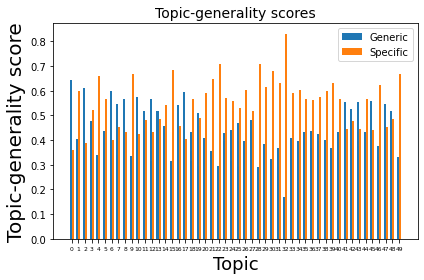

In [6]:
# Genericity aggregate figure 
from genericity_aggregate_phis import *
from matplotlib.pyplot import figure

figure(figsize=(32, 6), dpi=80)

keys = sorted(total_phis)
generic_vals = []
specific_vals = []

for key in keys:
    generic = generic_phis[key]
    specific = specific_phis[key]
    total = generic + specific
    print((total + unclear_phis[key]) / total_phis[key])
    generic_vals.append(generic / total)
    specific_vals.append(specific / total)

x = np.arange(len(keys))

width = 0.3 # the width of the bars
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, generic_vals, width, label='Generic')
rects2 = ax.bar(x + width/2, specific_vals, width, label='Specific')
ax.set_ylabel('Topic-generality score', fontsize=20)
ax.set_xlabel('Topic', fontsize=18)
ax.set_title('Topic-generality scores', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(keys, rotation=0, fontsize=6)

ax.legend()
# ax.bar_label(rects1, padding=6)
# ax.bar_label(rects2, padding=6)
fig.tight_layout()
plt.show()


1.0002211729488033
1.000090633057318
0.9999870853601094
1.000012171102437
0.9999793135198997
1.0000131659677658
1.0005710001015313
1.0003003131704473
1.0000587251732547
0.9999555273335788
1.0000131694352201
1.0000523773423975
1.0001985308996686
1.0001633827423657
0.9999556835514246
1.0000095854821587
1.000023418244567
0.9999805571379099
0.9999978835059234
0.9999847503896959
0.9999944272026224
0.9999957650131677
1.00020163709161
0.9999603459217676
0.9999678929198623
1.0001614819844236
0.999965870114593
1.0000024917244579
1.0001368102263373
0.9999825185296272
1.0002444856658714
1.0000082611198735
1.0002723273539373
0.999996765354441
0.9999915467856377
0.9999759065609265
1.0005382694331895
1.000008328761567
1.0000736180035454
0.9999943302259566
1.0000254167224536
1.0000888490786057
1.0000006082169668
0.999988171106056
0.9999595533051538
1.000001583878749
0.9999871856315697
1.0000402837560545
0.9999556806376116
1.0002568922350057
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


<Figure size 2560x480 with 0 Axes>

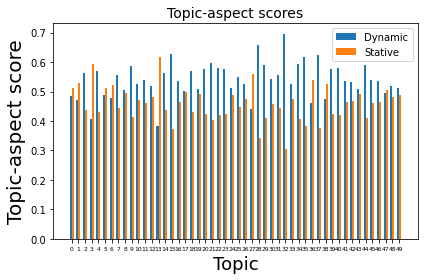

In [5]:
from matplotlib.pyplot import figure
from aspect_aggregate_phis import *

figure(figsize=(32, 6), dpi=80)

keys = sorted(total_phis)
dynamic_vals = []
stative_vals = []

for key in keys:
    dynamic = dynamic_phis[key]
    stative = stative_phis[key]
    total = dynamic + stative
    print((dynamic + stative + unclear_phis[key]) / total_phis[key])
    dynamic_vals.append(dynamic / total)
    stative_vals.append(stative / total)

for index, val in enumerate(dynamic_vals):
    print(val + stative_vals[index])

x = np.arange(len(keys))

width = 0.3 # the width of the bars
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, dynamic_vals, width, label='Dynamic')
rects2 = ax.bar(x + width/2, stative_vals, width, label='Stative')
ax.set_ylabel('Topic-aspect score', fontsize=20)
ax.set_xlabel('Topic', fontsize=18)
ax.set_title('Topic-aspect scores', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(keys, rotation=0, fontsize=6)

ax.legend()
# ax.bar_label(rects1, padding=6)
# ax.bar_label(rects2, padding=6)
fig.tight_layout()
plt.show()

0 1.0001942304782205
1 1.0000696948317025
2 0.9999762303152733
3 0.9999869839529658
4 0.9999778774226675
5 1.0000039687288007
6 1.0005706334263993
7 1.0002837457773464
8 1.0000417493519203
9 0.9999514618586594
10 0.9999975886560044
11 1.0000406241656523
12 1.000189806434783
13 1.0001471133173028
14 0.9999522132346138
15 0.9999956332041814
16 1.0000025272950719
17 0.9999790553103379
18 0.999994107400975
19 0.999980116591161
20 0.9999910578563154
21 0.9999932948176519
22 1.000173139433517
23 0.9999561434784792
24 0.9999612580543178
25 1.000143256407131
26 0.9999529956965775
27 0.9999967301447906
28 1.000126436509789
29 0.999971711038636
30 1.0002719233477257
31 0.999995862122976
32 1.0002915832591035
33 0.9999963542109046
34 0.9999920702054053
35 0.9999726906445185
36 1.0006359823395372
37 0.999993877259996
38 1.0000550794931546
39 0.9999940496878963
40 1.0000092097120417
41 1.0000644880930825
42 0.9999841455394363
43 0.9999855733353608
44 0.9999547446930139
45 0.9999851888778702
46 0.99

<Figure size 2560x480 with 0 Axes>

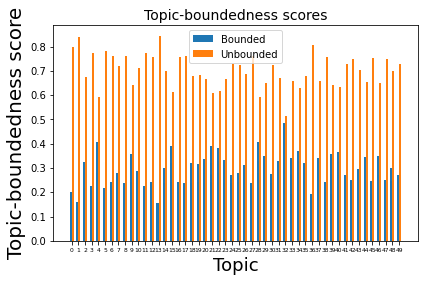

In [4]:
from matplotlib.pyplot import figure
from boundedness_aggregate_phis import *

figure(figsize=(32, 6), dpi=80)

keys = sorted(total_phis)
bounded_vals = []
unbounded_vals = []

for key in keys:
    total = bounded_phis[key] + unbounded_phis[key]
    bounded_vals.append(bounded_phis[key] / total)
    unbounded_vals.append(unbounded_phis[key] / total)

for index, val in enumerate(bounded_vals):
    print(val + unbounded_vals[index])

x = np.arange(len(keys))

width = 0.3 # the width of the bars
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, bounded_vals, width, label='Bounded')
rects2 = ax.bar(x + width/2, unbounded_vals, width, label='Unbounded')
ax.set_ylabel('Topic-boundedness score', fontsize=20)
ax.set_xlabel('Topic', fontsize=18)
ax.set_title('Topic-boundedness scores', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(keys, rotation=0, fontsize=6)

ax.legend()
# ax.bar_label(rects1, padding=6)
# ax.bar_label(rects2, padding=6)
fig.tight_layout()
plt.show()

In [27]:
import math

def get_confidence_intervals(props, data):
    up_ci = []
    low_ci = []
    for index, value in enumerate(data):
        standard_error = math.sqrt((props[index] * (1 - props[index]))/value)
        up_ci.append(props[index] + (standard_error * 1.96))
        low_ci.append(props[index] - (standard_error * 1.96))
    return low_ci, up_ci

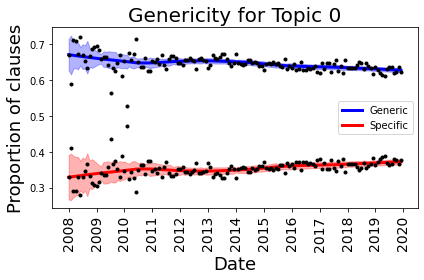

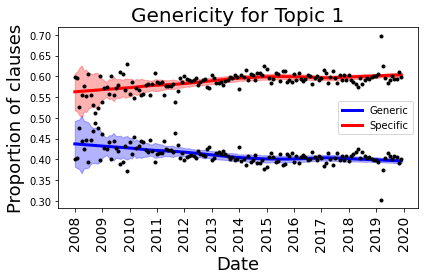

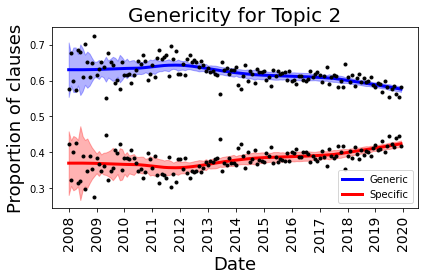

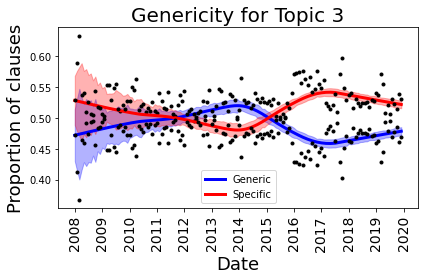

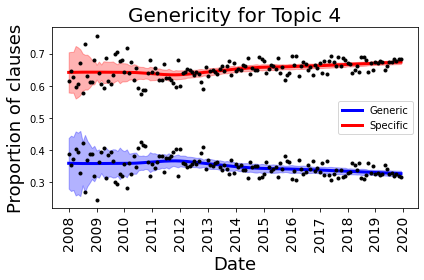

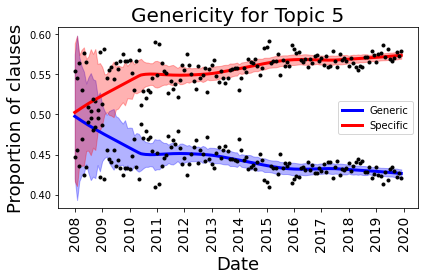

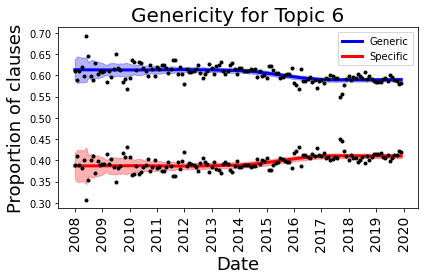

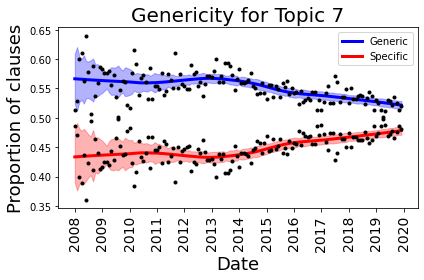

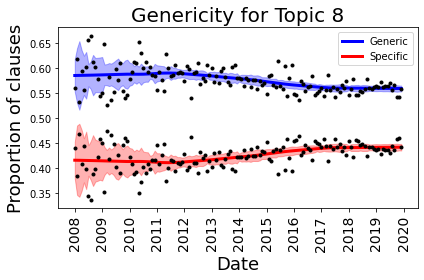

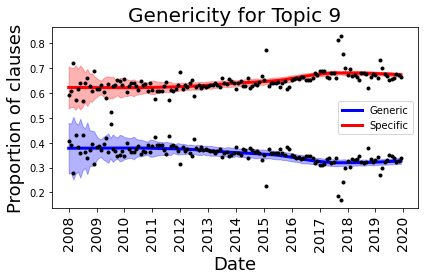

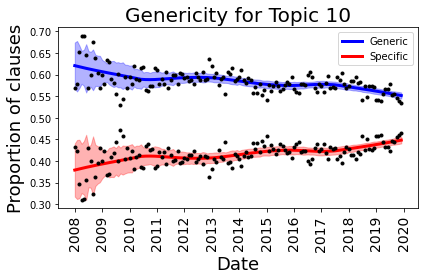

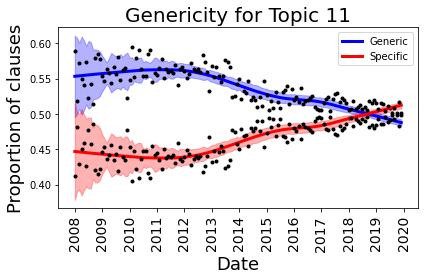

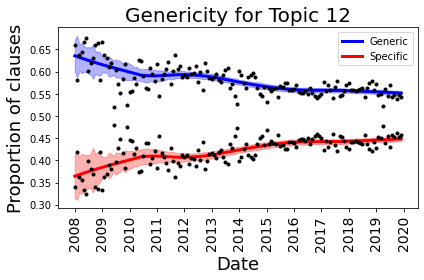

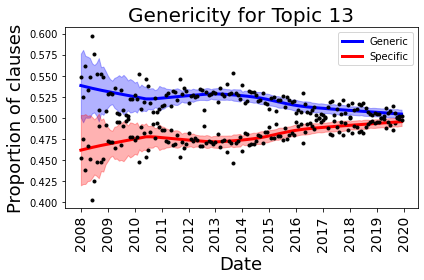

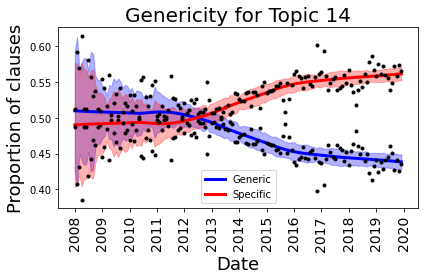

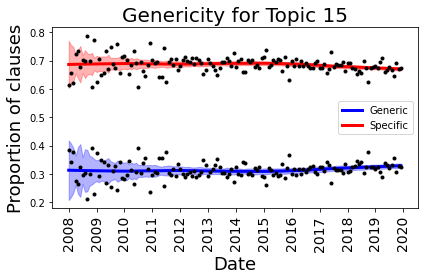

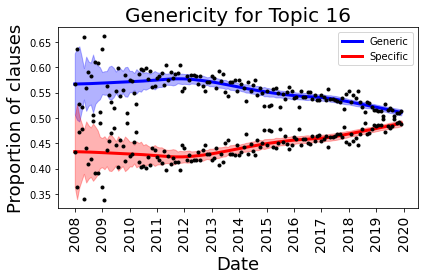

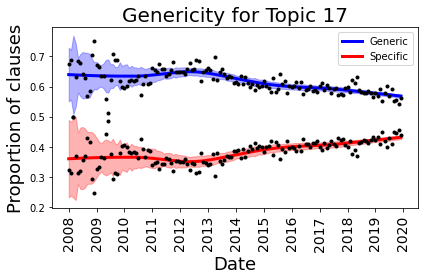

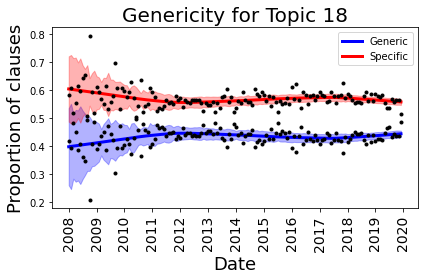

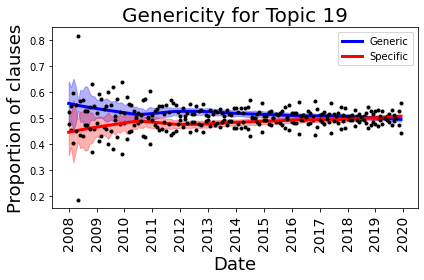

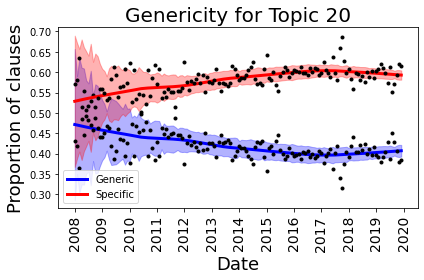

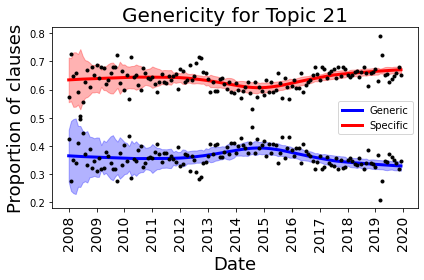

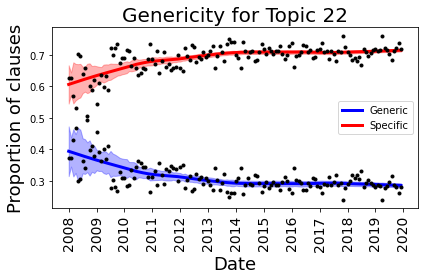

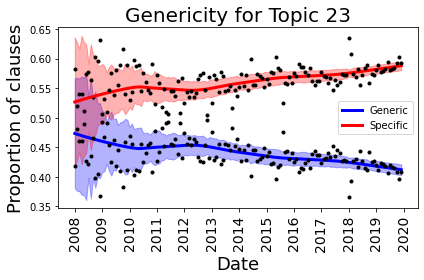

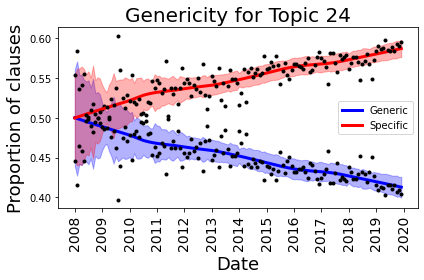

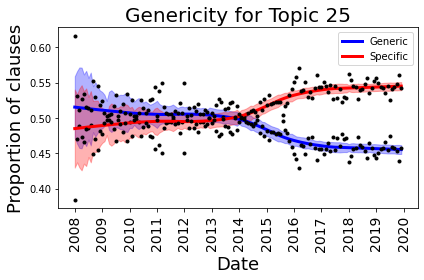

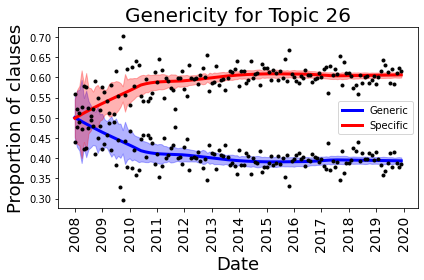

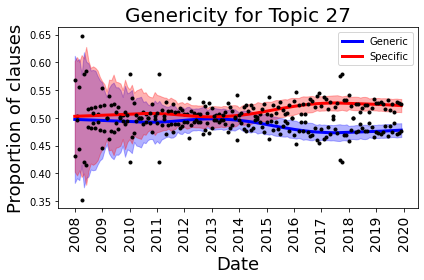

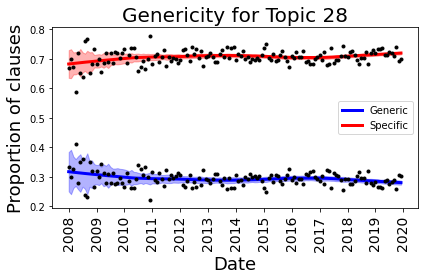

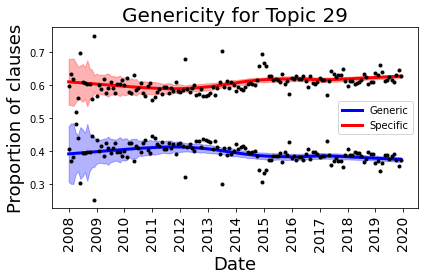

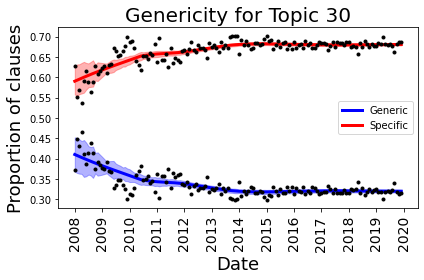

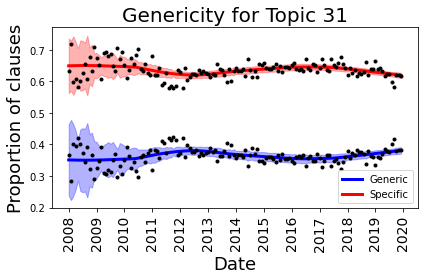

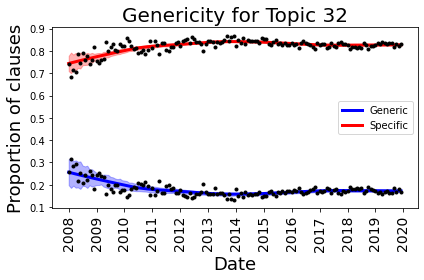

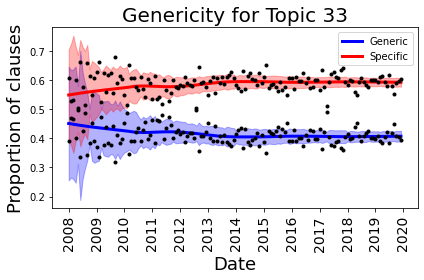

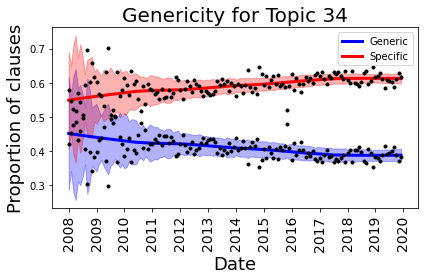

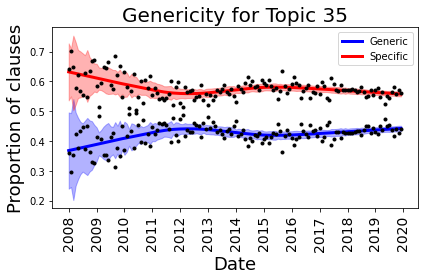

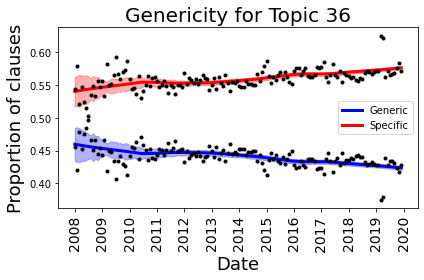

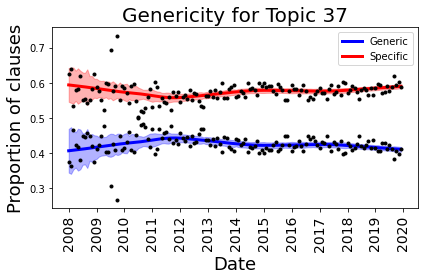

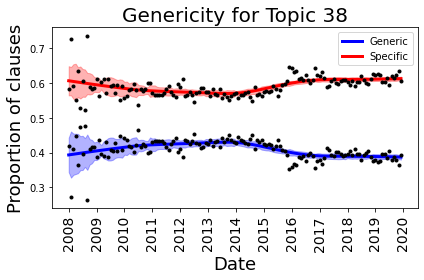

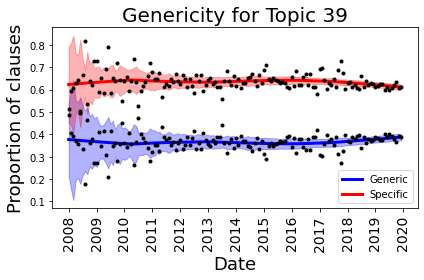

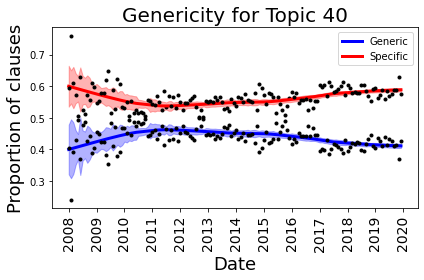

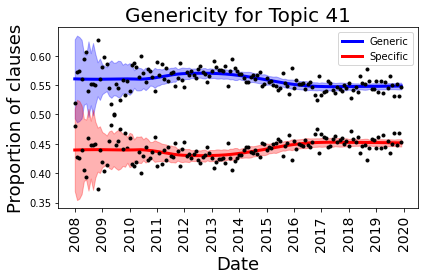

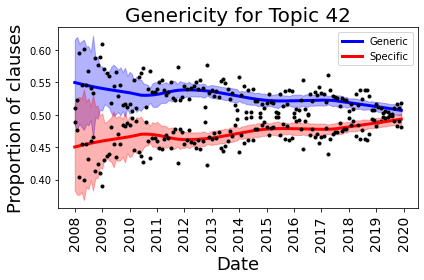

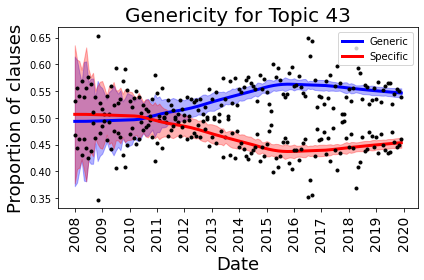

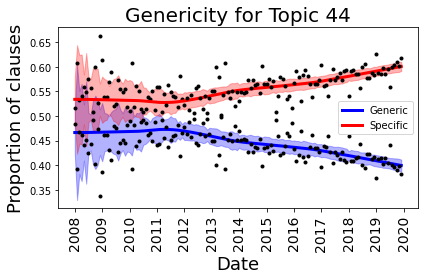

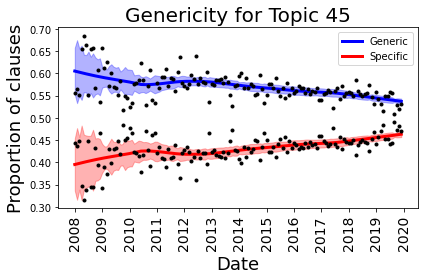

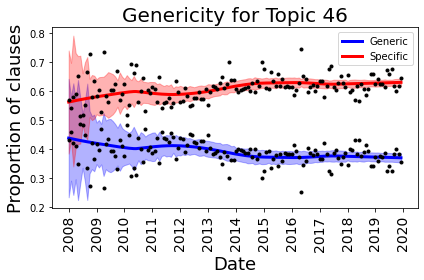

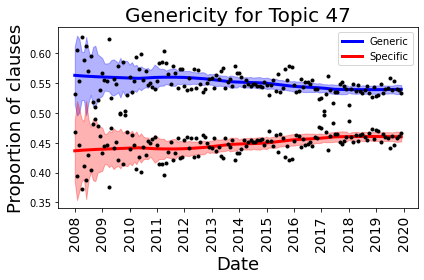

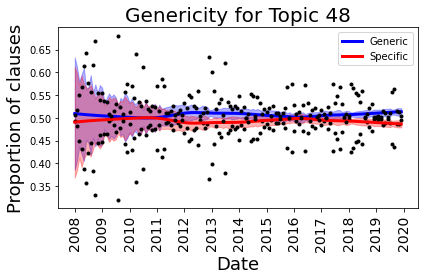

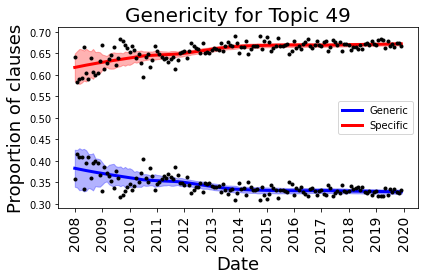

In [39]:
########################
# TEMPORAL ANALYSIS
########################
from sklearn.linear_model import LinearRegression
from tsmoothie.smoother import *
from genericity_temporal_phis import * 
# generic_temporal_phis.pop('0-0')
# generic_temporal_phis.pop('121-8295')

for topic in range(50):

    TOPIC = topic
    TITLE = 'Genericity for Topic ' + str(TOPIC)
    filename = 'figures/topics_temporal/genericity/genericity_' + str(TOPIC) + '.png'

    keys = []
    generic_values = []
    generic_count = []
    specific_values = []
    specific_count = []

    for date in generic_temporal_phis:
        keys.append(date)
        total = generic_temporal_phis[date][TOPIC][1] + specific_temporal_phis[date][TOPIC][1]
        generic_count.append(generic_temporal_phis[date][TOPIC][1])
        generic_values.append(generic_temporal_phis[date][TOPIC][1] / total)
        specific_count.append(specific_temporal_phis[date][TOPIC][1])
        specific_values.append(specific_temporal_phis[date][TOPIC][1] / total)

    tick_locs = [i*12 for i in range(13)]
    ticks = [(2008+i) for i in range(13)]

    smoother = LowessSmoother(smooth_fraction=0.4, iterations=1)
    smoother.smooth(generic_values)
    low_pi, up_pi = smoother.get_intervals('prediction_interval')
    low_ci, up_ci = get_confidence_intervals(smoother.smooth_data[0], generic_count)
    # low_ci, up_ci = smoother.get_intervals('confidence_interval')
    plt.plot(smoother.smooth_data[0], linewidth=3, color='blue', label='Generic')
    plt.plot(smoother.data[0], '.k', color='blue')
    # plt.fill_between(range(len(smoother.data[0])), low_pi[0], up_pi[0], alpha=0.3, color='blue')
    plt.fill_between(range(len(smoother.data[0])), low_ci, up_ci, alpha=0.3, color='blue')

    smoother = LowessSmoother(smooth_fraction=0.4, iterations=1)
    smoother.smooth(specific_values)
    low_pi, up_pi = smoother.get_intervals('prediction_interval')
    low_ci, up_ci = get_confidence_intervals(smoother.smooth_data[0], specific_count)
    # low_ci, up_ci = smoother.get_intervals('confidence_interval')
    plt.plot(smoother.smooth_data[0], linewidth=3, color='red', label='Specific')
    plt.plot(smoother.data[0], '.k', color='red')
    # plt.fill_between(range(len(smoother.data[0])), low_pi[0], up_pi[0], alpha=0.3, color='blue')
    plt.fill_between(range(len(smoother.data[0])), low_ci, up_ci, alpha=0.3, color='red')

    plt.title(TITLE, fontsize=20)
    plt.xticks(tick_locs,ticks, rotation='vertical',fontsize=14)
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('Proportion of clauses', fontsize=18)
    plt.tight_layout()
    plt.legend()
    plt.savefig(filename, facecolor='w', transparent=False)
    plt.show()